In [2]:
# MobileNetV2-based Emotion Detection with FER-2013
# Handles class imbalance using class weights

import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# 1. TensorFlow version check
print(f"Using TensorFlow version {tf.__version__}")

Using TensorFlow version 2.19.0


In [3]:
# 2. Keras and preprocessing imports
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback

In [4]:
# 3. Paths
DATA_DIR = r"D:\OFFICE WORK\KDD Summer 2025\emotion-detection\split_data"
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VAL_DIR   = os.path.join(DATA_DIR, 'val')
TEST_DIR  = os.path.join(DATA_DIR, 'test')

In [5]:
# 4. Parameters
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 10
NUM_EMOTIONS = 7
class_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# 5. Custom class weights based on training set distribution
# [angry=2971, disgust=328, fear=3072, happy=5393, neutral=3718, sad=3646, surprise=2401]
train_counts = np.array([2971, 328, 3072, 5393, 3718, 3646, 2401])
total_train = np.sum(train_counts)
class_weights = {i: total_train / (len(train_counts) * c) for i, c in enumerate(train_counts)}

In [6]:
# 6. Data generators (RGB)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 21529 images belonging to 7 classes.
Found 7174 images belonging to 7 classes.
Found 7184 images belonging to 7 classes.


In [7]:
# 7. Model architecture
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*IMAGE_SIZE, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(NUM_EMOTIONS, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 8. Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

def on_batch_end(batch, logs=None):
    print(f"Batch {batch+1}: loss={logs['loss']:.4f}, acc={logs['accuracy']:.4f}")

batch_logger = LambdaCallback(on_train_batch_end=on_batch_end)

In [8]:
# 9. Training
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    class_weight=class_weights,
    callbacks=[early_stop, batch_logger],
    verbose=1
)

C:\Users\hamza\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
Batch 1: loss=3.0248, acc=0.1875
  1/673 ━━━━━━━━━━━━━━━━━━━━ 1:54:08 10s/step - accuracy: 0.1875 - loss: 3.0248Batch 2: loss=2.4574, acc=0.1875
  2/673 ━━━━━━━━━━━━━━━━━━━━ 6:15 560ms/step - accuracy: 0.1875 - loss: 2.7411 Batch 3: loss=2.3708, acc=0.1667
  3/673 ━━━━━━━━━━━━━━━━━━━━ 7:21 659ms/step - accuracy: 0.1806 - loss: 2.6177Batch 4: loss=2.3774, acc=0.1641
  4/673 ━━━━━━━━━━━━━━━━━━━━ 8:44 784ms/step - accuracy: 0.1764 - loss: 2.5576Batch 5: loss=2.3330, acc=0.1562
  5/673 ━━━━━━━━━━━━━━━━━━━━ 8:31 765ms/step - accuracy: 0.1724 - loss: 2.5127Batch 6: loss=2.2805, acc=0.1771
  6/673 ━━━━━━━━━━━━━━━━━━━━ 8:21 752ms/step - accuracy: 0.1732 - loss: 2.4740Batch 7: loss=2.2514, acc=0.1875
  7/673 ━━━━━━━━━━━━━━━━━━━━ 8:17 747ms/step - accuracy: 0.1752 - loss: 2.4422Batch 8: loss=2.6228, acc=0.1836
  8/673 ━━━━━━━━━━━━━━━━━━━━ 8:11 738ms/step - accuracy: 0.1763 - loss: 2.4648Batch 9: loss=2.7371, acc=0.1701
  9/673 ━━━━━━━━━━━━━━━━━━━━ 8:07 734ms/step - accuracy: 0.1756 - 

225/225 ━━━━━━━━━━━━━━━━━━━━ 160s 712ms/step - accuracy: 0.2649 - loss: 1.6785

Test Accuracy: 40.97%

225/225 ━━━━━━━━━━━━━━━━━━━━ 67s 283ms/step

Classification Report:

              precision    recall  f1-score   support

       angry       0.35      0.13      0.19       992
     disgust       0.17      0.17      0.17       110
        fear       0.41      0.06      0.10      1025
       happy       0.57      0.59      0.58      1799
     neutral       0.33      0.51      0.40      1241
         sad       0.31      0.49      0.38      1216
    surprise       0.52      0.55      0.54       801

    accuracy                           0.41      7184
   macro avg       0.38      0.36      0.34      7184
weighted avg       0.42      0.41      0.38      7184



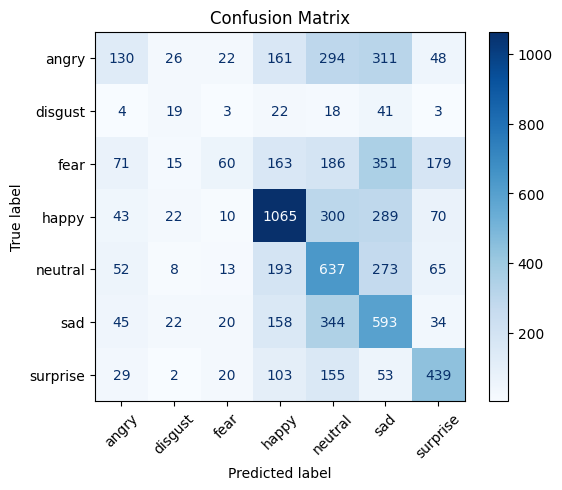

In [9]:
# 10. Evaluation
loss, acc = model.evaluate(test_generator)
print(f"\nTest Accuracy: {acc * 100:.2f}%\n")

Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels).plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# 11. Save
model.save(os.path.join(DATA_DIR, 'emotion_mobilenet.h5'))

In [10]:
# 12. Real-time webcam inference
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
cap = cv2.VideoCapture(0)
while True:
    ret, frame = cap.read()
    if not ret:
        break
    faces = face_cascade.detectMultiScale(frame, 1.3, 5)
    for (x, y, w, h) in faces:
        face = frame[y:y+h, x:x+w]
        face = cv2.resize(face, IMAGE_SIZE)
        face_norm = face.astype('float32') / 255.0
        face_input = np.expand_dims(face_norm, axis=0)
        preds = model.predict(face_input)
        label = class_labels[np.argmax(preds)]
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0,255,0), 2)
        cv2.putText(frame, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,255,255), 2)
    cv2.imshow('Emotion Detection', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━